<a href="https://colab.research.google.com/github/ViniciusMangueira/Data_Science/blob/main/Avalia%C3%A7%C3%A3o_de_Risco_de_Cr%C3%A9dito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previsão do Risco de Crédito com Machine Learning!

Hoje é dia 08/03/2021 e ainda estamos em pandemia. Com isso, a economia ainda está muito abalada e várias pessoas não estão cumprindo com suas dívidas.

Uma forma de amenizar o prejuízo para bancos, empresários e afins é prever se uma pessoa vai conseguir pagar sua conta no mês ou não, pois assim a empresa em questão pode se preparar para o que vira.

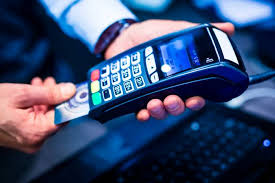

Neste projeto, será construído um modelo de Machine Learning que irá prever se uma pessoa será inadimplente ou não.

Para isso, iremos usar o dataset da Nubank o qual você encontra nesse [link](http://dl.dropboxusercontent.com/s/xn2a4kzf0zer0xu/acquisition_train.csv?dl=0).

## Importação dos dados

Inicialmente, vamos importar as bibliotecas e o dataset e na sequência veremos o formato do arquivo e os tipos dos atributos!

In [ ]:
# filtrar mensagens de warning
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# instalar Pandas Profiling
!pip install scikit-plot -q
!pip install imbalanced-learn -q

In [ ]:
# Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report
from scikitplot.metrics import plot_confusion_matrix, plot_roc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#Arquivo
df = pd.read_csv("http://dl.dropboxusercontent.com/s/xn2a4kzf0zer0xu/acquisition_train.csv?dl=0")

In [ ]:
# Formato do arquivo
print("O arquivo tem {} linhas e {} colunas!".format(df.shape[0], df.shape[1]))

O arquivo tem 45000 linhas e 43 colunas!


In [ ]:
# Tipos dos atributos
df.dtypes

ids                                                  object
target_default                                       object
score_1                                              object
score_2                                              object
score_3                                             float64
score_4                                             float64
score_5                                             float64
score_6                                             float64
risk_rate                                           float64
last_amount_borrowed                                float64
last_borrowed_in_months                             float64
credit_limit                                        float64
reason                                               object
income                                              float64
facebook_profile                                     object
state                                                object
zip                                     

## Analise Inicial

Vamos dar uma olhada nas 5 primeiras entradas para retirarmos alguns insights do dataset.

In [ ]:
# Visualização das 5 primeiras entradas do arquivo
df.head()

,ids,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,reason,income,facebook_profile,state,zip,channel,job_name,real_state,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_applied,application_time_in_funnel,email,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_first_name,external_data_provider_fraud_score,lat_lon,marketing_channel,profile_phone_number,reported_income,shipping_state,shipping_zip_code,profile_tags,user_agent,target_fraud
0,343b7e7b-2cf8-e508-b8fd-0a0285af30aa,False,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,25033.92,36.0,0.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65014.12,True,sjJbkqJS7cXalHLBFA+EOQ==,Ernn+uVXCMq/6ARrBCcd+A==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,NaN,0.0,0.0,18.0,18.0,07:52:34,444,outlook.com,NaN,2,0.0,51.0,leidelaura,645,"(-29.151545708122246, -51.1386461804385)",Invite-email,514-9840782,57849.0,BR-MT,17528,"{'tags': ['n19', 'n8']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
1,bc2c7502-bbad-0f8c-39c3-94e881967124,False,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,NaN,NaN,39726.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,100018.91,False,xsd3ZdsI3356I3xMxZeiqQ==,rlWIXTBO+VOa34+SpGyhlQ==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,50.0,0.0,0.0,14.0,14.0,02:34:29,346,gmail.com,0.0,1,0.0,17.0,diocezio,243,"(-19.687710705798963, -47.94151536525154)",Radio-commercial,251-3659293,4902.0,BR-RS,40933,"{'tags': ['n6', 'n7', 'nim']}",Mozilla/5.0 (Linux; Android 5.0.2; SAMSUNG SM-...,NaN
2,669630dd-2e6a-0396-84bf-455e5009c922,True,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.0,100.027073,0.351918,112.892453,0.29,7207.92,36.0,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65023.65,NaN,Ygq6MsM98oC8yceExr69Ig==,PjTIDfJsK0DKL9fO7vuW2g==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,NaN,0.0,0.0,10.0,NaN,00:60:02,6,gmail.com,NaN,2,NaN,9.0,veralucia,65,"(-28.748023890412284, -51.867279334353995)",Waiting-list,230-6097993,163679.0,BR-RR,50985,"{'tags': ['n0', 'n17', 'nim', 'da']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
3,d235609e-b6cb-0ccc-a329-d4f12e7ebdc1,False,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,510.0,101.599485,0.987673,94.902491,0.32,NaN,NaN,54591.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,68830.01,False,KET/Pmr6rHp1RJ/P9ymztw==,Cc/kWDLQH3dpHv5HU+pLVA==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiE56f...,n+xK9CfX0bCn77lClTWviw==,NaN,1.0,0.0,19.0,19.0,11:20:49,406,spgov.com,NaN,3,NaN,38.0,venice,815,"(-17.520650158450454, -39.75801139933186)",Waiting-list,261-3543751,1086.0,BR-RN,37825,{'tags': ['n4']},Mozilla/5.0 (Linux; Android 6.0; HTC One X10 B...,NaN
4,9e0eb880-e8f4-3faa-67d8-f5cdd2b3932b,False,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.0,98.474289,0.532539,118.126207,0.18,NaN,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,60011.29,True,xsd3ZdsI3356I3xMxZeiqQ==,i036nmJ7rfxo+3EvCD7Jnw==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,NaN,0.0,0.0,11.0,NaN,13:39:03,240,gmail.com,0.0,2,1.0,46.0,darzisa,320,"(-16.574259446978008, -39.90990074785962)",Invite-email,102-3660162,198618.0,BR-MT,52827,"{'tags': ['pro+aty', 'n19', 'da', 'b19']}",Mozilla/5.0 (Linux; Android 7.0; Pixel C Build...,NaN


Em uma primeira vista, temos que o dataset está bem poluído com informações codificadas, erradas e faltantes.

Por exemplo:

* As variáveis `ids`, `profile_phone_number`, ‘email`, ‘shipping_zip_code`, ‘marketing_channel’ são irrelevantes.

*  `score_1`, `score_2`, `reason`, `state`, `zip`, `channel`, `job_name`, `real_state` estão codificadas.

* `Profile_tags`, `user_agent`, `lat_lon`, `application_time_applied` tem dados que não vão ser utilizados.

Vamos excluir essas colunas agora.

In [ ]:
# Remover coluna do Id
df_new = df.drop(labels=['ids', 'profile_phone_number', 'email', 'shipping_zip_code', 'marketing_channel'], axis=1)

In [ ]:
# Remover colunas codificadas
df_new = df_new.drop(labels=['score_1', 'score_2', 'reason', 'state', 'zip', 'channel', 'job_name', 'real_state'], axis=1)

In [ ]:
# Remover colunas que nao vao ser utilizadas
df_new = df_new.drop(labels=['profile_tags', 'user_agent', 'lat_lon', 'application_time_applied'], axis =1)

### Outliers

Na sequência, iremos visualizar algumas estatísticas do dataset afim de notarmos se existem outliers ou dados errôneos cadastrados!

In [ ]:
# Visualizar estatisticas
df_new.describe()

,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_in_funnel,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,reported_income
count,44438.000000,45000.000000,45000.000000,45000.000000,44438.000000,15044.000000,15044.000000,31200.000000,4.443800e+04,18455.000000,44303.000000,44426.000000,44438.000000,33456.000000,45000.000000,22372.0,45000.000000,29876.000000,42767.000000,45000.000000,45000.00
mean,347.983258,100.006797,0.500037,99.925228,0.296717,13782.341991,41.763893,34381.951154,7.160739e+04,35.069737,0.076270,0.004569,10.696701,11.068119,247.537000,0.0,1.501067,0.503381,12.534781,500.399800,inf
std,110.429165,3.178080,0.288326,10.016549,0.101933,8077.571933,10.252705,36586.982218,5.185897e+04,21.663194,0.274052,0.079400,4.592463,4.595501,146.118398,0.0,1.114941,0.499997,126.530487,287.968873,NaN
min,0.000000,86.191572,0.000035,60.663039,0.000000,1005.180000,36.000000,0.000000,4.821180e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-999.000000,0.000000,403.00
25%,270.000000,97.867036,0.252150,93.198353,0.220000,7519.502500,36.000000,10000.000000,4.501078e+04,17.000000,0.000000,0.000000,7.000000,8.000000,120.000000,0.0,1.000000,0.000000,11.000000,252.000000,50948.25
50%,340.000000,100.018900,0.500753,99.974796,0.290000,12023.465000,36.000000,25647.000000,6.126676e+04,32.000000,0.000000,0.000000,10.000000,10.000000,248.000000,0.0,2.000000,1.000000,27.000000,503.000000,101779.00
75%,420.000000,102.141797,0.748816,106.640275,0.360000,19220.270000,36.000000,47086.750000,8.601923e+04,50.000000,0.000000,0.000000,13.000000,14.000000,375.000000,0.0,2.000000,1.000000,43.000000,747.000000,151337.25
max,990.000000,113.978234,0.999973,142.192400,0.900000,35059.600000,60.000000,448269.000000,5.000028e+06,141.000000,5.000000,5.000000,49.000000,49.000000,500.000000,0.0,3.000000,1.000000,59.000000,1000.000000,inf


* É possível notar que as variáveis `score_3`, `last_amount_borrowed`, `credit_limit` e `ok_since` possuem outliers.

* Além disso, `external_data_provider_email_seen_before` possui o valor mínimo de -999 (provavelmente esse valor representa um dado faltante) e `reported_income` possui dados `inf` os quais vamos tratar.

Para ambos os casos acima, vamos trocar os dados citados por NaN.

In [ ]:
# substituir inf por nan em reported_income 
df_new['reported_income'] = df_new['reported_income'].replace(np.inf,
                                                                  np.nan)

#  substituir -999 em external_data_provider_email_seen_before por NaN
df_new.loc[df_new['external_data_provider_email_seen_before'] == -999.0,
             'external_data_provider_email_seen_before'] = np.nan

* Por último, temos que ` external_data_provider_credit_checks_last_2_year` só possui valores nulos e `0`, dessa forma vamos excluir essa coluna!

In [ ]:
# Eliminar a coluna external_data_provider_credit_checks_last_2_year
df_new.drop('external_data_provider_credit_checks_last_2_year', axis=1, inplace=True)

### Dados faltantes

Na sequência, queremos verificar a integridade do nosso dataset. Para isto, veremos se existem dados faltantes e a quantidade de valores únicos de cada atributo no dataset.

In [ ]:
# Visualizar quantidade de dados faltantes
df_new.isnull().sum().sort_values(ascending=False)

target_fraud                                       43478
last_amount_borrowed                               29956
last_borrowed_in_months                            29956
ok_since                                           26545
external_data_provider_credit_checks_last_year     15124
credit_limit                                       13800
n_issues                                           11544
facebook_profile                                    4458
target_default                                      3259
external_data_provider_email_seen_before            2879
n_bankruptcies                                       697
n_defaulted_loans                                    574
n_accounts                                           562
income                                               562
risk_rate                                            562
score_3                                              562
reported_income                                       67
application_time_in_funnel     

In [ ]:
# Visualizar a porcentagem de dados faltantes de cada atributo
(df_new.isnull().sum()/df.shape[0]).sort_values(ascending=False)

target_fraud                                       0.966178
last_amount_borrowed                               0.665689
last_borrowed_in_months                            0.665689
ok_since                                           0.589889
external_data_provider_credit_checks_last_year     0.336089
credit_limit                                       0.306667
n_issues                                           0.256533
facebook_profile                                   0.099067
target_default                                     0.072422
external_data_provider_email_seen_before           0.063978
n_bankruptcies                                     0.015489
n_defaulted_loans                                  0.012756
n_accounts                                         0.012489
income                                             0.012489
risk_rate                                          0.012489
score_3                                            0.012489
reported_income                         

In [ ]:
# Valores únicos
print("\nVALORES ÚNICOS:")
print(df_new.nunique().sort_values())


VALORES ÚNICOS:
target_default                                         2
external_data_provider_credit_checks_last_year         2
facebook_profile                                       2
last_borrowed_in_months                                2
target_fraud                                           2
external_data_provider_credit_checks_last_month        4
n_defaulted_loans                                      5
n_bankruptcies                                         6
shipping_state                                        25
n_issues                                              44
n_accounts                                            44
external_data_provider_email_seen_before              61
risk_rate                                             82
score_3                                               88
ok_since                                             100
application_time_in_funnel                           501
external_data_provider_fraud_score                  1001
last_amount_bo

Pelo que vimos acima, `target_fraud` possui aproximadamente 96% dos seus dados faltantes e a nossa variável alvo `target_default` também possui valores faltantes. 

Visto isso, vamos excluir toda a coluna `target_fraud` e excluir as linhas dos valores faltantes de `target_default`.


In [ ]:
# Eliminar a coluna target_fraud
df_new.drop('target_fraud', axis=1, inplace=True)

# Eliminar as entradas onde target_default é NaN
df_new.dropna(subset=['target_default'], inplace=True)

### Correlação 

Outro fator importante é a correlação entre as variáveis.

Abaixo vemos que no nosso dataset, as variáveis não tem correlações entre si.  Com isso, não podemos fazer muitas observações.


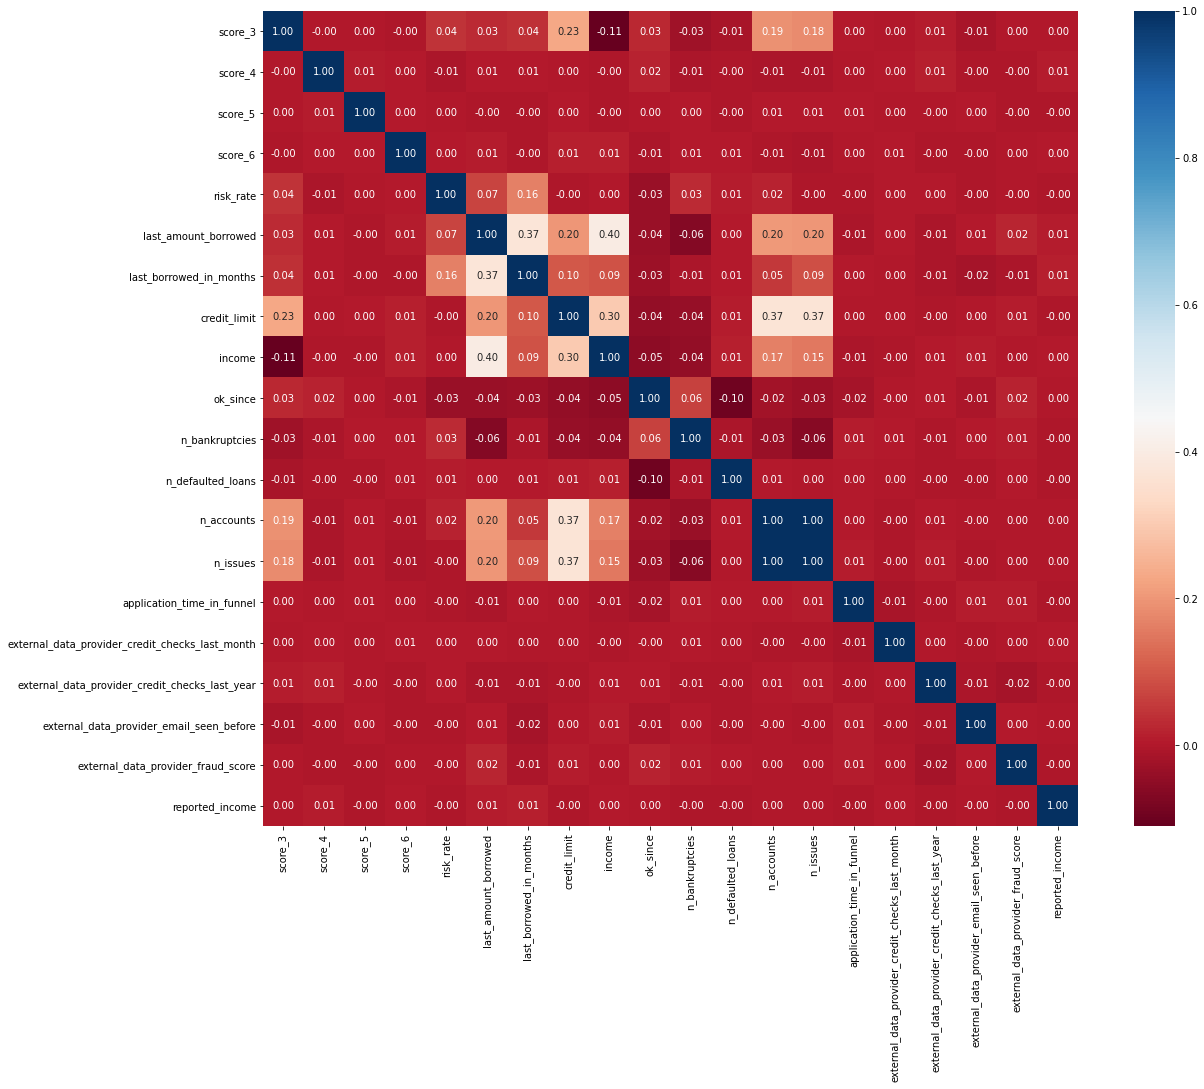

In [ ]:
# Correlação
corr = df_new.corr()
ax, fig = plt.subplots(figsize=(20,15))
sns.heatmap(corr,cmap='RdBu', fmt='.2f', square=True, linecolor='white', annot=True);

### Distribuição dos dados de `target_defautl`

Ao fim da nossa análise inicial, queremos ver se os dados da nossa variável alvo `target_default` estão balanceados.

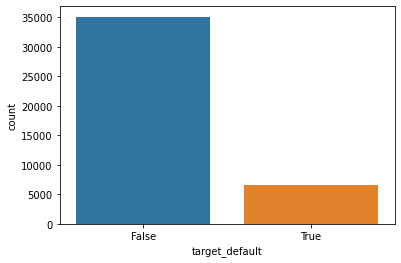

In [ ]:
# Quantidade de dados de target_default
sns.countplot(df_new.target_default);

Como vemos no gráfico acima, os dados não estão balanceados. Visto isso, vamos balanceá-los aplicando o método de Undersampling futuramente.

## Modelo

Feita a análise inicial, queremos agora preparar nosso dataset para a construção do nosso modelo de Machine Learning.

Para relembrar, queremos prever a probabilidade de um cliente da Nubank deixar de pagar a sua fatura do Cartão de Crédito. Dessa forma, tanto acurácia quanto o recall são importantes e vamos levar isso em consideração na criação do modelo.

Mas antes, precisamos tratar agora dos dados faltantes que sobraram.


### Preparação dos dados

Primeiramente iremos separar os atributos categóricos e numéricos. 

In [ ]:
# Separar atributos categoricos e numericos
num_df = df_new.select_dtypes(exclude='object').columns
cat_df = df_new.select_dtypes(include='object').columns

Posteriormente, vamos substituir os valores faltantes das variáveis `last_amount_borrowed`, `last_borrowed_in_months` e `n_issues` por 0, pois ambas possuem mais de 50% dos dados faltantes.

In [ ]:
# Substituição de valores ausentes
df_new.last_amount_borrowed.fillna(value=0, inplace=True)
df_new.last_borrowed_in_months.fillna(value=0, inplace=True)
df_new.n_issues.fillna(value=0, inplace=True)

Além delas, iremos substituir os valores nulos das outras variáveis numéricas pela média dos seus valores. 

In [ ]:
# Substituição de valores ausentes das variáveis numéricas
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer = imputer.fit(df_new.loc[:,num_df])
df_new.loc[:,num_df] = imputer.transform(df_new.loc[:,num_df])

Por fim, os dados faltantes das variáveis categóricas vão ser substituídos pelo valor de maior frequência.

In [ ]:
# Substituição de valores ausentes das variáveis categóricas
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer = imputer.fit(df_new.loc[:,cat_df])
df_new.loc[:,cat_df] = imputer.transform(df_new.loc[:,cat_df])

Abaixo vemos que todos os dados faltantes foram substituídos!

In [ ]:
# verificar a quantidade de dados nulos
df_new.isnull().sum()

target_default                                     0
score_3                                            0
score_4                                            0
score_5                                            0
score_6                                            0
risk_rate                                          0
last_amount_borrowed                               0
last_borrowed_in_months                            0
credit_limit                                       0
income                                             0
facebook_profile                                   0
ok_since                                           0
n_bankruptcies                                     0
n_defaulted_loans                                  0
n_accounts                                         0
n_issues                                           0
application_time_in_funnel                         0
external_data_provider_credit_checks_last_month    0
external_data_provider_credit_checks_last_year

### Normalização dos dados

Para melhorar o nosso modelo, vamos normalizar os dados.

In [ ]:
scaled_df = df_new.copy()

# Normalizar as colunas numéricas
num_cols = scaled_df.drop('target_default', axis=1).select_dtypes(exclude='object').columns
scaled_df[num_cols] = StandardScaler().fit_transform(scaled_df[num_cols].values)

Além disso, vamos utilizar o LabelEncoding para codificar as variáveis categóricas. 

In [ ]:
encoded_df = scaled_df.copy()
# extrair as colunas categóricas
cat_cols = encoded_df.select_dtypes('object').columns

# codificar cada coluna categórica
for col in cat_cols:
  encoded_df[col+'_encoded'] = LabelEncoder().fit_transform(encoded_df[col])
  encoded_df.drop(col, axis=1, inplace=True)

### Separação dos datasets de treinamento e teste

Por fim, vamos separar a variável alvo das demais e dividir o dataset entre dados de treino/teste e, posteriormente, padronizar os dados e fazer um Undersampling como foi dito anteriormente.

In [ ]:
# separar as variáveis independentes da variável alvo
X = encoded_df.drop('target_default', axis=1).select_dtypes(exclude='object')
y = encoded_df['target_default']

# dividir o dataset entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [ ]:
# Padronizar os  dados,
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

In [ ]:
#  Under Sampling
rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_sample(X_train, y_train)

## Escolha do melhor Modelo

Nessa etapa, queremos ver qual modelo se encaixa melhor para o nosso dataset. Para isso, iremos testar o recall e ver qual possui o melhor desempenho.

In [ ]:
def val_model(X, y, clf, quite=False):
    """
    Realiza cross-validation com os dados de treino para determinado modelo.

    # Arguments
        X: DataFrame, contém as variáveis independetes.
        y: Series, vetor contendo a variável alvo.
        clf: modelo classificador do Scikit-learn.
        quite: bool, indicando se a função deve imprimir os resultados ou não.

    # Returns
        float, média dos scores da cross-validation.
    """
    
    X = np.array(X)
    y = np.array(y)

    pipeline = make_pipeline(StandardScaler(), clf)
    scores = cross_val_score(pipeline, X, y, scoring='recall')

    if quite == False:
        print("Recall: {:.2f} (+/- {:.2f})".format(scores.mean(), scores.std()))
    
    return scores.mean()

Iremos testar os modelos:

* RandomForestClassifier	
* DecisionTreeClassifier	
* SGDClassifier	
* SVC	
* LogisticRegression	
* XGBClassifier	
* LGBMClassifier

In [ ]:
# instanciar modelos
rf = RandomForestClassifier(random_state=0)
dt = DecisionTreeClassifier(random_state=0)
sgdc = SGDClassifier(random_state=0)
svc = SVC(random_state=0)
lr = LogisticRegression(random_state=0)
xgb = XGBClassifier(random_state=0)
lgbm = LGBMClassifier(random_state=0)

model = []
recall = []
# avaliar o desempenho (recall)
for clf in (rf, dt, sgdc, svc, lr, xgb, lgbm):
    model.append(clf.__class__.__name__)
    recall.append(val_model(X_train_rus, y_train_rus, clf, quite=True))

pd.DataFrame(data=recall, index=model, columns=['recall'])

,recall
RandomForestClassifier,0.593979
DecisionTreeClassifier,0.540776
SGDClassifier,0.561729
SVC,0.593981
LogisticRegression,0.592041
XGBClassifier,0.613179
LGBMClassifier,0.606486


Logo, o melhor modelo foi o XGBoost!

Na sequência, iremos escolher os melhores parâmetros para o XGBoost.


## Escolha dos Parâmetros:

Vamos procurar os melhores valores para os respectivos parâmetros: 

* **learning_rate**
* **n_estimators**
* **min_child_weight**

In [ ]:
xgb = XGBClassifier(random_state=0)

param_grid = {
 'learning_rate': [0.005, 0.05, 0.1, 0.3, 0.5, 0.7, 1]
}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.6043264576203249 para {'learning_rate': 0.1}


In [ ]:
xgb = XGBClassifier(learning_rate=0.1, random_state=0)

param_grid = {
 'n_estimators':range(0,300,10),
}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.610102673203219 para {'n_estimators': 150}


In [ ]:
xgb = XGBClassifier(learning_rate=0.1, n_estimators=150, random_state=0)

param_grid = {
 'min_child_weight':range(1,10,1)
}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.6101085314340332 para {'min_child_weight': 2}


Vamos agora aplicar o modelo com os melhores parâmetros no subdataset de treino e ver nosso aproveitamento do recall.

              precision    recall  f1-score   support

         0.0       0.90      0.66      0.76      5301
         1.0       0.25      0.62      0.35       961

    accuracy                           0.65      6262
   macro avg       0.58      0.64      0.56      6262
weighted avg       0.80      0.65      0.70      6262

AUC: 0.6371



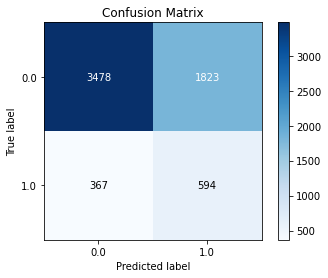

In [ ]:
# modelo final
xgb = XGBClassifier(learning_rate=0.1, n_estimators=150, min_child_weight=2, random_state=0)
xgb.fit(X_train_rus, y_train_rus)

# fazer a previsão
X_test = scaler.transform(X_test)
y_pred = xgb.predict(X_test)

# Classification Report
print(classification_report(y_test, y_pred))

# imprimir a área sob a curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

# plotar matriz de confusão
plot_confusion_matrix(y_test, y_pred)
plt.show()

In [ ]:
# previsões e probabilidades em cima do dataset de teste
y_pred = xgb.predict(X_test)

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred)))

Acurácia: 0.6305



## Conclusão 

Ao fim do projeto, foram rodados vários métodos afim de otimizar o nosso modelo.

Chegamos a uma taxa de acurácia de aproximadamente 63%, que é uma taxa minimamente satisfatória assim como uma boa taxa de recall.
